In [8]:
import datasets
from datasets import load_dataset
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments

In [9]:
train_dataset = load_dataset("../../data/data2/train", data_files="_annotations.coco.json")['train']
test_dataset = load_dataset("../../data/data2/test", data_files="_annotations.coco.json")['train']
valid_dataset = load_dataset("../../data/data2/valid", data_files="_annotations.coco.json")['train']

In [10]:
train_dataset

Dataset({
    features: ['info', 'licenses', 'categories', 'images', 'annotations'],
    num_rows: 1
})

In [11]:
categories = {}
for i in range(len(train_dataset['categories'][0])):
    categories[train_dataset['categories'][0][i]['id']] = train_dataset['categories'][0][i]['name']
categories

{0: 'Hover-jEwm', 1: 'Hoverfly'}

In [12]:
def make_dataset(dataset, path):
    images = []
    
    current_box = []
    current_areas = []
    current_category_ids = []
    current_ids = []

    image_id = 0    
    print('size =', len(dataset['annotations'][0]))
    for i in range(len(dataset['annotations'][0])):
        if i % 100 == 0:
            print(i)
        current = dataset['annotations'][0][i]
        if current['image_id'] != image_id:
            image = {}

            current_image = dataset['images'][0][image_id]            

            image['image_id'] = current_image['id']
            image['image'] = Image.open(f'../../data/data2/{path}/{current_image["file_name"]}')
            image['height'] = current_image['height']
            image['width'] = current_image['width']
            
            temp = {}

            temp['id'] = current_ids
            temp['area'] = current_areas
            temp['bbox'] = current_box
            temp['category'] = current_category_ids

            image['objects'] = temp           

            current_box = []
            current_areas = []
            current_category_ids = []
            current_ids = []

            images += [image]

            image_id += 1

        current_box += [current['bbox']]
        current_areas += [current['area']]
        current_category_ids += [current['category_id']]
        current_ids += [current['id']]
    return images

In [13]:
train = datasets.Dataset.from_list(make_dataset(train_dataset, 'train'))
test = datasets.Dataset.from_list(make_dataset(test_dataset, 'test'))
valid = datasets.Dataset.from_list(make_dataset(valid_dataset, 'valid'))

size = 267
0


100
200
size = 20
0
size = 20
0


In [14]:
train

Dataset({
    features: ['image_id', 'image', 'height', 'width', 'objects'],
    num_rows: 263
})

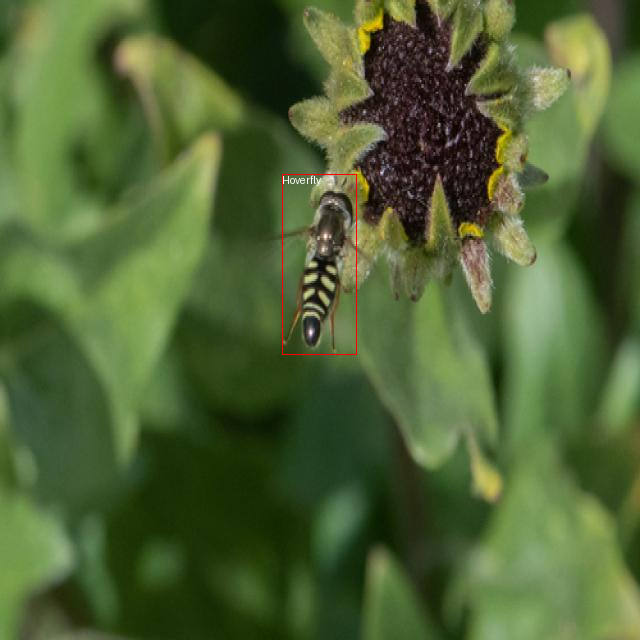

In [15]:
idx = 2

image = train[idx]["image"]
annotations = train[idx]["objects"]
draw = ImageDraw.Draw(image)


id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["area"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    if max(box) > 1.0:
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), categories[class_idx], fill="white")

image

In [16]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--facebook--detr-resnet-50. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Could not find image pro

In [17]:
transform = albumentations.Compose(
    [
        albumentations.Resize(256, 256)
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [18]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [19]:
train = train.with_transform(transform_aug_ann)

In [20]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [21]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model 

In [22]:
training_args = TrainingArguments(
    output_dir='/output',
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [27]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train,
    tokenizer=image_processor,
)

trainer.train()

 15%|█▌        | 50/330 [38:03<3:35:50, 46.25s/it]

{'loss': 2.9559, 'grad_norm': 195.58885192871094, 'learning_rate': 8.484848484848486e-06, 'epoch': 1.52}


 30%|███       | 100/330 [1:05:46<1:43:23, 26.97s/it]

{'loss': 2.0273, 'grad_norm': 9021.0048828125, 'learning_rate': 6.969696969696971e-06, 'epoch': 3.03}


 45%|████▌     | 150/330 [1:29:06<1:24:06, 28.04s/it]

{'loss': 1.5774, 'grad_norm': 41.94051742553711, 'learning_rate': 5.4545454545454545e-06, 'epoch': 4.55}


 61%|██████    | 200/330 [1:52:34<1:00:26, 27.90s/it]

{'loss': 1.4999, 'grad_norm': 306.6447448730469, 'learning_rate': 3.93939393939394e-06, 'epoch': 6.06}


 76%|███████▌  | 250/330 [2:16:13<37:55, 28.44s/it]  

{'loss': 1.3714, 'grad_norm': 253.2417449951172, 'learning_rate': 2.4242424242424244e-06, 'epoch': 7.58}


 91%|█████████ | 300/330 [2:39:35<13:56, 27.87s/it]

{'loss': 1.3182, 'grad_norm': 69.83661651611328, 'learning_rate': 9.090909090909091e-07, 'epoch': 9.09}


100%|██████████| 330/330 [2:53:31<00:00, 31.55s/it]

{'train_runtime': 10411.4301, 'train_samples_per_second': 0.253, 'train_steps_per_second': 0.032, 'train_loss': 1.740685931119052, 'epoch': 10.0}


TrainOutput(global_step=330, training_loss=1.740685931119052, metrics={'train_runtime': 10411.4301, 'train_samples_per_second': 0.253, 'train_steps_per_second': 0.032, 'train_loss': 1.740685931119052, 'epoch': 10.0})

In [28]:
import json

def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [29]:
import torchvision

In [32]:
!pip install pycocotools

   ---------------------------------------- 0.0/85.1 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.1 kB ? eta -:--:--
   -------------- ------------------------- 30.7/85.1 kB 445.2 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/85.1 kB 245.8 kB/s eta 0:00:01
   -------------------------------------- - 81.9/85.1 kB 419.2 kB/s eta 0:00:01
   ---------------------------------------- 85.1/85.1 kB 368.9 kB/s eta 0:00:00


In [33]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(test)
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [34]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

Some weights of the model checkpoint at devonho/detr-resnet-50_finetuned_cppe5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 7/7 [00:28<00:00,  4.06s/it]

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [35]:
train[0]

{'pixel_values': tensor([[[-0.6623, -0.6623, -0.6452,  ..., -0.2171, -0.2171, -0.2171],
          [-0.6623, -0.6623, -0.6452,  ..., -0.2171, -0.2171, -0.2171],
          [-0.6452, -0.6452, -0.6452,  ..., -0.2342, -0.2342, -0.2342],
          ...,
          [ 0.3481,  0.3481,  0.3309,  ..., -0.6623, -0.5938, -0.5938],
          [ 0.3481,  0.3481,  0.3309,  ..., -0.6452, -0.5767, -0.5767],
          [ 0.3481,  0.3481,  0.3309,  ..., -0.6452, -0.5767, -0.5767]],
 
         [[ 1.3256,  1.3256,  1.3256,  ...,  1.3782,  1.3782,  1.3782],
          [ 1.3256,  1.3256,  1.3256,  ...,  1.3782,  1.3782,  1.3782],
          [ 1.3256,  1.3256,  1.3256,  ...,  1.3782,  1.3782,  1.3782],
          ...,
          [ 1.9384,  1.9384,  1.9209,  ...,  0.7129,  0.7479,  0.7479],
          [ 1.9384,  1.9384,  1.9209,  ...,  0.7829,  0.8179,  0.8179],
          [ 1.9384,  1.9384,  1.9209,  ...,  0.7829,  0.8179,  0.8179]],
 
         [[ 0.9842,  0.9842,  0.9842,  ...,  1.1585,  1.1585,  1.1585],
          [ 

Detected Hoverfly with confidence 0.536 at location [135.58, 97.83, 429.52, 560.52]


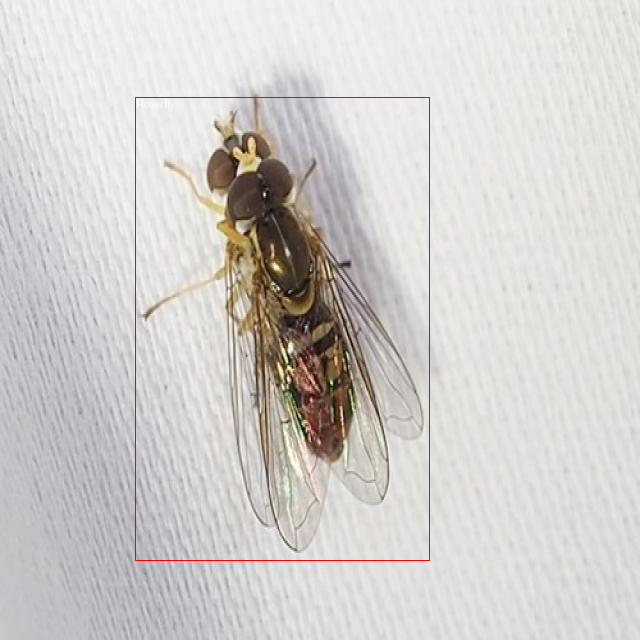

In [42]:
idx = 0
image = Image.open('../../data/data2/test/' + test_dataset['images'][0][idx]["file_name"])
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {categories[label.item() - 1]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), categories[label.item() - 1], fill="white")

image